In [1]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph

In [2]:
from littlegrad.engine import Value

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

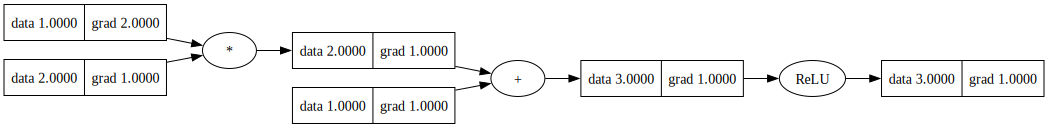

In [4]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

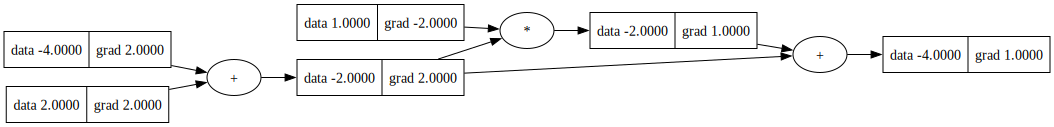

In [5]:
#my own test for incest cases (child and parent making child nodes)
a = Value(-4.0)
b = Value(2.0)
c = a + b
c += c * 1

c.backward()
draw_dot(c)

NEW TOPO SORT (worked cuz it can detect and avoid incest cases):
        nodeList = []
        visitedNodes = set()

        def getNodes(val):
            if val not in visitedNodes:
                for child in val.children:
                    getNodes(child)
                nodeList.append(val)
                visitedNodes.add(val)
        getNodes(self)
        visitedNodes.reverse()

OLD TOPO SORT (didn't work, couldn't identify or avoid incest cases):
        childList = []
        def getChildren(val):
            if val not in childList:
                childList.append(val)
                for child in val.children:
                    getChildren(child)
        getChildren(self)

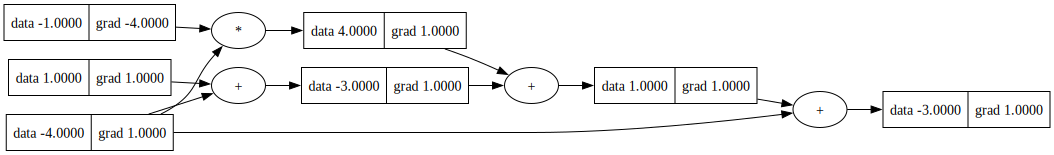

In [6]:
#my own test for correct neg() bookeeping
a = Value(-4.0)
b = Value(2.0)
c = a
c += 1 + c + (-a)
c.backward()
draw_dot(c)

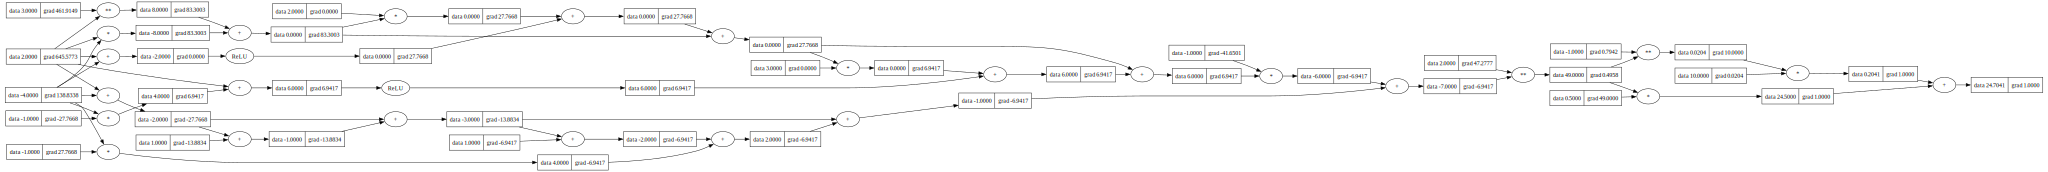

In [7]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
g.backward()
draw_dot(g)

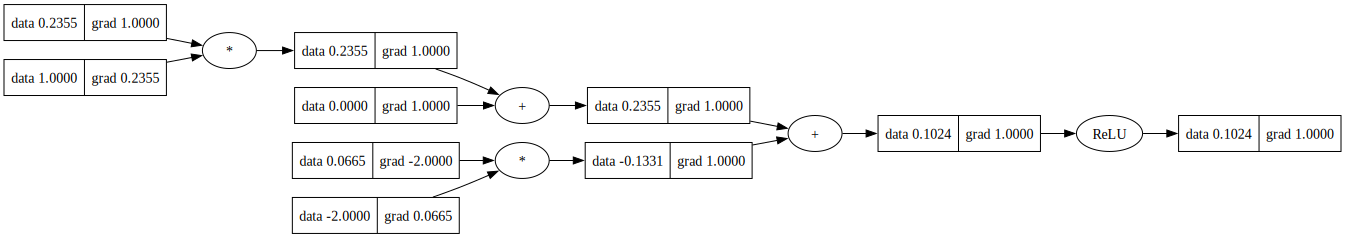

In [8]:
# a simple 2D neuron
import random
from littlegrad import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

In [9]:
dot.render('gout')

'gout.svg'